# Idea:
In the purpose of exploring elementary cellular automata more I've decided to research some possible classification methods. This classification of ECA is based on the change of the various neighbourhood patterns (111, 000, 101, ...) throughout the evolution of the system. It classifies ECA rules as one of the three classes:
* constant - number of given pattern is the same in almost every time step (<30%)
* random - number of given pattern is changing randomly
* unstable - number of given pattern is changing in almost every time step (>70%)

In [13]:
import numpy as np
import time
import itertools
from itertools import tee, chain
import pandas as pd
from statsmodels.sandbox.stats.runs import runstest_1samp 
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

In [14]:
def eca_get_lut(rule_num):
  return np.array([int(x) for x in bin(rule_num)[2:].zfill(8)], dtype=np.uint8)

def eca_evolve(lut, x):
  return lut[7 - (np.roll(x, 1) * 4 + x * 2 + np.roll(x, -1))]

def eca_steps(rule, config, steps):
    current_config = config
    for step in range(steps):
        current_config = eca_evolve(rule, current_config)
    return current_config

def space_time_diagram(rule, config, steps):
    space_time_diagram = config
    current_config = config
    for step in range(steps):
        current_config = eca_evolve(rule, current_config)
        space_time_diagram = np.vstack((space_time_diagram, current_config))
    return space_time_diagram

#funkcja zliczająca nakładające się patterny np. dla konfiguracji [0 1 1 1 1 1 0] ilość patternów 111 wynosi 3 ponieważ mamy 3 takie sąsiedztwa.
def overlapping_occurences(string, sub):
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count

#funkcja zliczająca występowanie danego patternu w kolejnych krokach czasowych
def calculate_occurences(rule, config, steps, pattern):
    occurences = []
    diagram = space_time_diagram(rule, config, steps)
    ext_diagram = np.empty((diagram.shape[0], diagram.shape[1]+2), dtype = np.int8)
    for idx, row in enumerate(diagram):
        ext_diagram[idx] = np.pad(row,(1,1), constant_values=(row[-1], row[0]), mode='constant')
    for row in ext_diagram:
        str_row = ''.join(str(x) for x in row)
        occurences.append(overlapping_occurences(str_row, pattern))
    return occurences

#funkcja wyliczająca zmianę występowalności patternu tzn. zmiana nastąpiła jeśli w kroku czasowym t+1 ilość patternów różniła się od ilości w kroku t
def calculate_change(occurences):
    change = 0
    for idx, value in enumerate(occurences[:-1]):
        if occurences[idx] != occurences[idx+1]:
            change +=1
    return change

def eca_visualize(rule_nr, config, steps):
    rule = eca_get_lut(rule_nr)
    diagram = space_time_diagram(rule, config, steps)
    plt.imshow(diagram, cmap = 'binary')
    plt.title("Space-time diagram of ECA {0}".format(rule_nr))
    plt.ylabel("Time step")
    plt.xlabel("Cell Index")
    plt.show()

def classify(column):
    if column <= 0.30:
        return "Constant"
    elif column >= 0.70:
        return "Unstable"
    else:
        return "Random"

In [15]:
patterns = list(map(list, itertools.product([0, 1], repeat = 3)))
patterns = [''.join(str(x) for x in pattern) for pattern in patterns]

Dla każdej reguły badam jeden space-time diagram o ilości kroków czasowych równej 99, powstały z randomowo wylosowanej konfiguracji początkowej o długości 99. 

In [16]:
length = 99
initial_configuration = np.random.randint(2, size=length)

dicts = []
rules = []

for rule in range(256):
    patterns_change = {}
    for pattern in patterns:
        rule_lut = eca_get_lut(rule)
        eval = calculate_occurences(rule_lut, initial_configuration, 99, pattern)
        patterns_change[pattern] = round(calculate_change(eval)/99, 2)
    rules.append(patterns_change)

In [17]:
classification = pd.DataFrame.from_dict(rules)

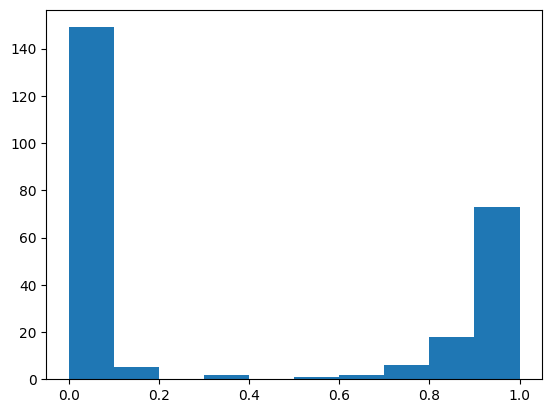

In [18]:
plt.hist(classification['010'])
plt.show()

Na oko sprawdzając histogram zmian dla patternu 010 możemy wyróżnić klasy o małej zmienności i bardzo dużej zmienności. Jednocześnie mamy też bardzo nieliczną klasę o średniej zmienności. Nie dokońca wiedziałam jak je odpowiednio nazwać :) 

In [19]:
for column in classification:
    classification[column] = classification[column].apply(classify)

In [20]:
classification

,000,001,010,011,100,101,110,111
0,Constant,Constant,Constant,Constant,Constant,Constant,Constant,Constant
1,Unstable,Constant,Unstable,Unstable,Constant,Constant,Unstable,Unstable
2,Constant,Constant,Constant,Constant,Constant,Constant,Constant,Constant
3,Unstable,Constant,Unstable,Unstable,Constant,Constant,Unstable,Unstable
4,Constant,Constant,Constant,Constant,Constant,Constant,Constant,Constant
...,...,...,...,...,...,...,...,...
251,Constant,Constant,Constant,Constant,Constant,Constant,Constant,Constant
252,Constant,Constant,Constant,Constant,Constant,Constant,Constant,Constant
253,Constant,Constant,Constant,Constant,Constant,Constant,Constant,Constant
254,Constant,Constant,Constant,Constant,Constant,Constant,Constant,Constant


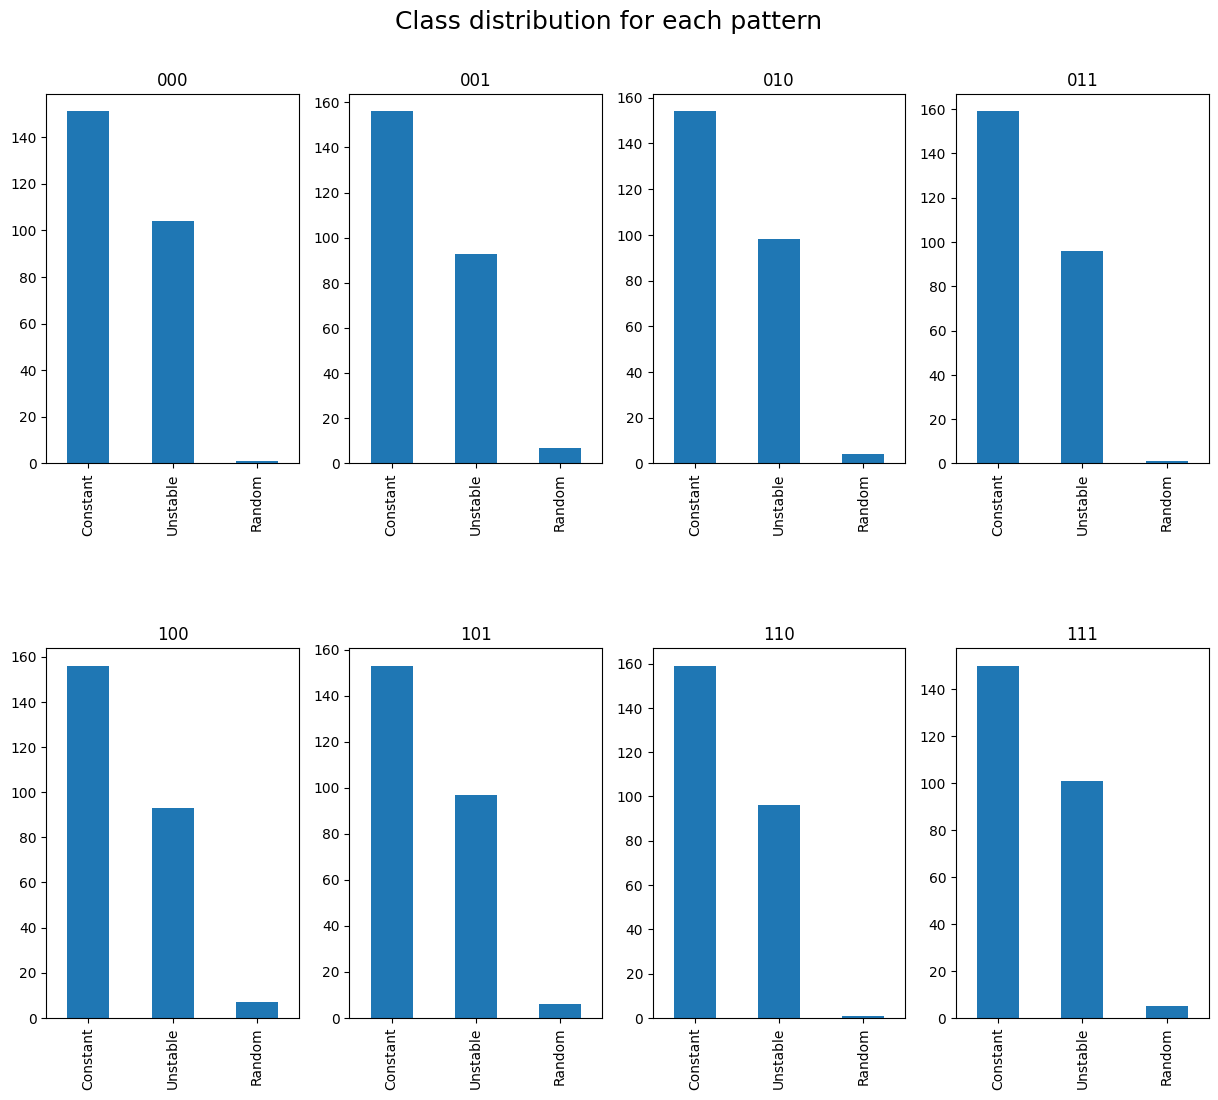

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Class distribution for each pattern", fontsize=18, y=0.95)
for column, ax in zip(classification.columns, axs.ravel()):
    classification[column].value_counts().plot(kind = 'bar', ax = ax)
    ax.set_title(column)
    


In [23]:
for column in classification:
    constant = classification.index[classification[column] == 'Constant'].tolist()
    random = classification.index[classification[column] == 'Random'].tolist()
    unstable = classification.index[classification[column] == 'Unstable'].tolist()
    print("\nPattern", column)
    print("\nConstant rules:", constant)
    print("\nRandom rules:", random)
    print("\nUnstable rules:", unstable)


Pattern 000

Constant rules: [0, 2, 4, 8, 10, 12, 13, 14, 16, 24, 28, 32, 34, 36, 40, 42, 43, 44, 46, 48, 50, 56, 57, 58, 64, 66, 68, 69, 70, 72, 76, 77, 78, 79, 80, 84, 92, 93, 94, 96, 98, 99, 100, 104, 108, 112, 113, 114, 116, 128, 130, 132, 136, 138, 139, 140, 141, 142, 143, 144, 152, 155, 156, 157, 158, 159, 160, 162, 163, 164, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255]

Random rules: [103]

Unstable rules: [1, 3, 5, 6, 7, 9, 11, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 33, 35, 37, 38, 39, 41, 45, 47, 49, 51, 52, 53, 54, 55, 59, 60, 61, 62, 63, 65, 67, 71, 73, 74, 75, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 95,